# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from specmatch_emp.specmatchemp import library
from specmatch_emp.specmatchemp.spectrum import read_hires_fits, read_fits
from specmatch_emp.specmatchemp.specmatch import SpecMatch

In [6]:
from astropy import constants as c
from astropy import units as u

In [7]:
lib = library.read_hdf()

Reading library from /home/azuckerman/.specmatchemp/library.h5


# Doppler shift

The Doppler shift is multiplicative, i.e.
$$
\lambda_{\mathrm{new}} = \lambda_{\mathrm{old}} \left(1 + \frac{v}{c}\right)
$$

To find the velocity shift, we therefore have
$$
\frac{v}{c} = \frac{\lambda_{\mathrm{new}}}{\lambda_{\mathrm{old}}} - 1
$$

We can also express this in log-space, i.e.
$$
\Delta[\log{\lambda}] = \log{\lambda_{\mathrm{new}}} - \log{\lambda_{\mathrm{old}}} = \log{\left(1 + \frac{v}{c}\right)}
$$

# Specmatch wavelength array

In [5]:
lib.wav[1:] / lib.wav[:-1]

array([1.00000339, 1.00000339, 1.00000339, ..., 1.00000339, 1.00000339,
       1.00000339])

The wavelength array has a constant spacing in log-lambda, i.e.
$$
\log{\lambda_{i+1}} - \log{\lambda_i} = k
$$

In [6]:
k = np.log(lib.wav[1]) - np.log(lib.wav[0])
k

3.393857177513837e-06

Comparing this to the above expression, we see that the single-pixel velocity shift is
$$
v/c = e^k - 1
$$

In [7]:
(np.exp(k) - 1) * c.c

<Quantity 1017.4545119 m / s>

As you point out, this is approximately 1 km/s. I don't recall if this was intentional (probably not!).

# Finding the velocity shift

In [9]:
spec = read_hires_fits('./rj59.1923.fits')
spec.plot(wavlim=(5160, 5200))

FileNotFoundError: [Errno 2] No such file or directory: './rj59.1923.fits'

Perform the shift

In [9]:
sm = SpecMatch(spec, lib)
sm.shift()

Shifting spectrum
Shifting spectrum rj59.1923
Attempting shift to spectrum NSO, median cross-correlation peak = 2.20
Attempting shift to spectrum 123239, median cross-correlation peak = 2.14
Attempting shift to spectrum 222368, median cross-correlation peak = 1.56
Attempting shift to spectrum 216899, median cross-correlation peak = 0.91
Best reference for shifting: NSO
Shifting entire spectrum


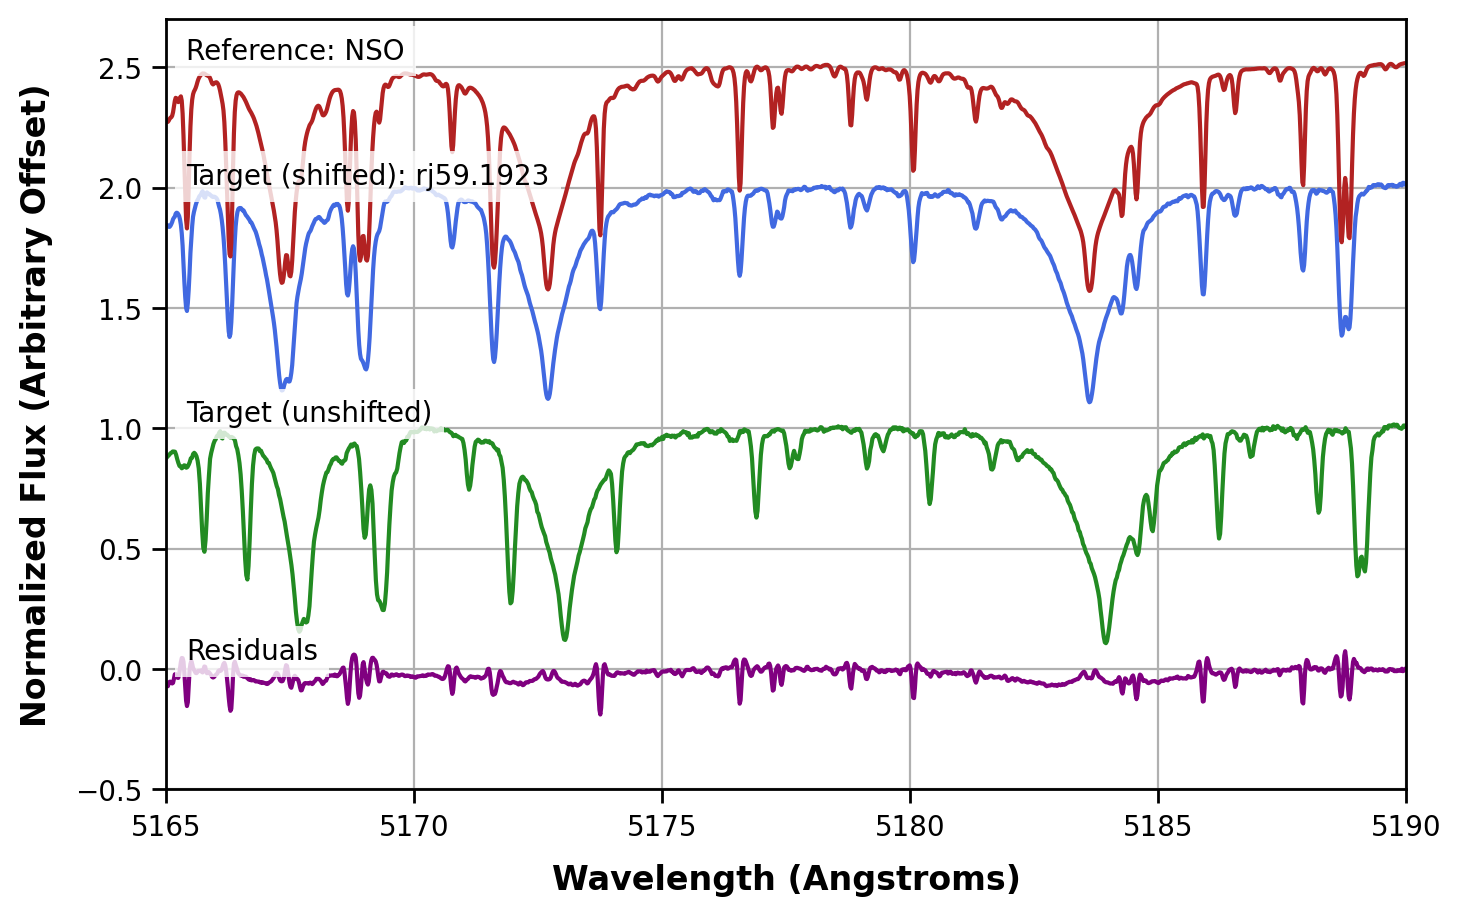

In [10]:
sm.plot_shifted_spectrum(wavlim=(5165, 5190))

Let's look at the shift result. The Mg b triplet that we are looking at is in order 2.

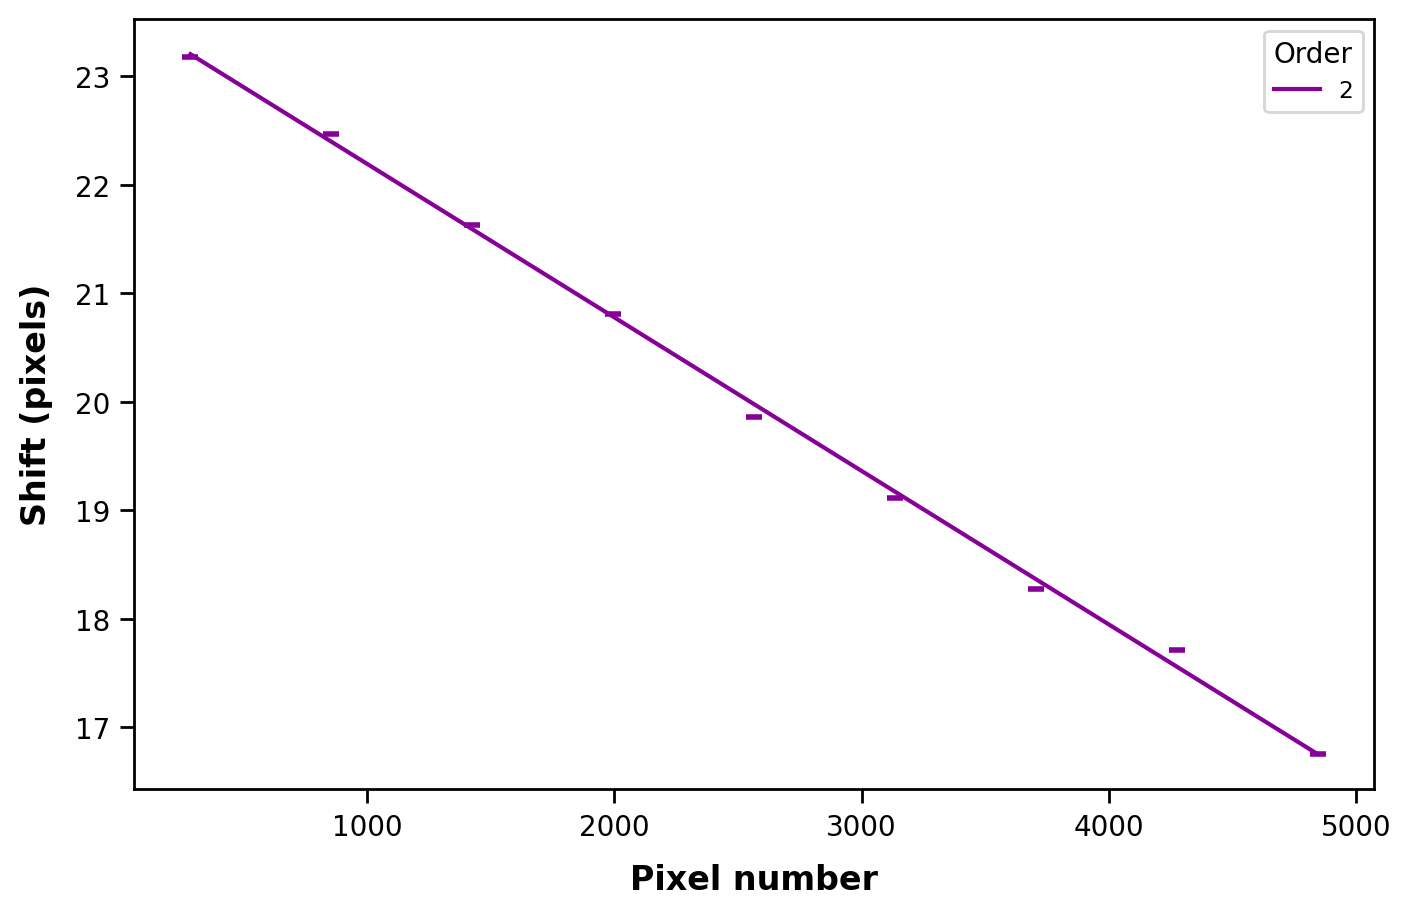

In [51]:
sm.plot_shift_lags(orders=2)

We saw from above that for a single-pixel shift, $v/c = e^k - 1$. For a shift of $n$ pixels, 
$$
\frac{v}{c} = e^{n\cdot k} - 1
$$
If we don't need high-precision velocities, then for this star the median pixel shift is ~ 20, so the velocity shift can be found simply:

In [8]:
mean_lag = np.mean(sm.shift_data['lag'])
range_lag = np.nanmax(sm.shift_data['lag']) - np.nanmin(sm.shift_data['lag'])
print('Mean pixel shifts is ' + str(mean_lag) + ', but varies by ' + str(range_lag) + ' across the spectrum.')


NameError: name 'sm' is not defined

In [123]:
approx_v = ((np.exp(mean_lag * k) - 1) * c.c).to(u.km/u.s)
approx_v

<Quantity 20.34194673 km / s>

But the spectrum we have is of HD 190406. According to [Gaia DR2](http://vizier.u-strasbg.fr/viz-bin/VizieR-S?Gaia%20DR2%201821708351374312064), this has a systemic RV of 5.19 km/s.

I suspect that the discrepancy is due to the missing barycentric correction; according to Jason Eastman's [site](https://astroutils.astronomy.osu.edu/exofast/barycorr.html), the correction for this observation is -17.107 km/s.

In [124]:
approx_v - 17.106 * (u.km/u.s)

<Quantity 3.23594673 km / s>

This brings us into the ballpark (given that the stretch across the spectrum spans 6 pixels, the uncertainty is at least 3 km/s).

# Which wavelengths?

Digging into the code, I see that center_pix actually refers to the center of the segment, _after_ the original spectrum has been resampled onto the library wavelength scale (constant in $\Delta \log{\lambda}$), but before it has been shifted.

I believe these are indeed the wavelengths stored in `attrs['w_original']`, though that has also been flattened from a 2D echelle. You'll have to change the code to access `s_rescaled`, `serr_rescaled`, and create the new array `w_rescaled` by stacking `w_ref_c` (see lines 182-184 of shift.py).

It's incorrect to simply subtract two wavelength arrays (since you don't know that they necessarily start at the same initial point in the spectrum).

# Which shift() function?

The shift.shift function is the procedure used to perform the shifting. You give it two Spectrum objects, and an optional store dict, and it returns a shifted and flattened spectrum.

In [139]:
from specmatchemp.shift import shift
shift?

Signature: shift(targ, ref, store=None, lowfilter=20)
Docstring:
Shifts the given spectrum by placing it on the same wavelength
scale as the specified reference spectrum, then solves for shifts
between the two spectra through cross-correlation.

Args:
    targ (Spectrum): Target spectrum
    ref (Spectrum): Reference spectrum
    store (optional [file or dict]): h5 file or dict to record
        diagnostic data.

Returns:
    shifted (Spectrum): Adjusted and flattened spectrum
File:      ~/Research/specmatch-emp/specmatchemp/shift.py
Type:      function


The sm.shift function is a convenience function that also performs a bootstrapped shifting process, choosing the best reference for the target's spectral type. It has no arguments since the target Spectrum is already contained in the SpecMatch object, while the reference is chosen automatically from the library.

I'm not sure why the `attrs` dict doesn't get stored correctly when calling it this way (according to the code, `sm.target` is set to the return value of `bootstrap_shift`, which in turn returns the value of `shift`. May be worth digging into the code, or you can use the above procedure to get the velocity shift.

In [138]:
sm.shift?

Signature: sm.shift()
Docstring:
Shift the target spectrum onto the library wavelength scale.

Uses the Mgb triplet region (5120 - 5200 A), a section of spectrum
containing much information, to determine which spectrum to use
as the reference for shifting. It does this by initially shifting
the target spectrum in that region to the allowed references and
comparing the heights of the cross-correlation peaks. The reference
with the highest median peak is used as the reference to shift the
entire spectrum.

Returns:
    spectrum.Spectrum: The shifted spectrum, which is also stored in
        self.target
File:      ~/Research/specmatch-emp/specmatchemp/specmatch.py
Type:      method
